## Resnet Model. All categories except Other(O). Images reoriented

We eliminate the images from Other diseases/abnormalities (O) class since each image has a different problem and we would be generalizing particularities which does not make sense and harms the model.

For this case, unlike the previous ones, the images have been flipped vertically so that both the right and left eyes images have the same shape.

### 00. Load libraries

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Rescaling, Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import ResNet50

import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

### 01. Load images
The images are separated into train, test and validation using the function of keras call image_dataset_from_directory

In [ ]:
train_dir = './labeled-images-flipped/train'
test_dir = './labeled-images-flipped/test'

BATCH_SIZE = 32
IMG_HEIGHT = 264
IMG_WIDTH = 264
EPOCHS = 200

input_shape = (IMG_WIDTH, IMG_HEIGHT, 3)

In [ ]:
# Creating generators (prepare data to feed the model)
training_generator = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    shuffle=True,
    seed=432,
    validation_split=0.2,
    subset='training',
)

validation_generator = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels='inferred',
    label_mode='categorical',
    batch_size=BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    shuffle=True,
    seed=432,
    validation_split=0.2,
    subset='validation',
)

test_generator = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    shuffle=False,
    batch_size=BATCH_SIZE,
    image_size=(IMG_WIDTH, IMG_HEIGHT),
    seed=432,
)

Found 5115 files belonging to 7 classes.
Using 4092 files for training.
Found 5115 files belonging to 7 classes.
Using 1023 files for validation.
Found 569 files belonging to 7 classes.


### 02. Model architecture

Loading of pretrained Resnet model with imagenet and creation of the architecture.

In [ ]:
pretrained = ResNet50(weights='imagenet', include_top=False)

In [ ]:
model = Sequential()

model.add(Rescaling(1./255, input_shape=input_shape))

model.add(pretrained)

model.add(Flatten())
model.add(Dense(256, activation='relu'))

model.add(Dense(256, activation='relu'))
#model.add(Dropout(0.2))

model.add(Dense(7))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 264, 264, 3)       0         
                                                                 
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 flatten (Flatten)           (None, 165888)            0         
                                                                 
 dense (Dense)               (None, 256)               42467584  
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 7)                 1799      
                                                                 
 activation (Activation)     (None, 7)                 0

### 03. Weight adjustment
As observed in the EDA, the classes were not balanced. In order for the model not to over-train, higher weights are given to those classes with fewer samples.

In [ ]:
cat_list = os.listdir('./labeled-images-flipped/train/')
cat_list.sort()
lenghts = [len(os.listdir('./labeled-images-flipped/train/'+cat)) for cat in cat_list]
total_train_images = np.sum(lenghts)

weights = list(np.sqrt(np.round(1/(np.array(lenghts) / total_train_images),2)))

print(cat_list)
print(lenghts)
print(weights)

['A', 'C', 'D', 'G', 'H', 'M', 'N']
[239, 264, 1447, 256, 115, 209, 2585]
[4.626013402488151, 4.402272140611028, 1.8788294228055935, 4.469899327725402, 6.669332800213226, 4.946716082412655, 1.407124727947029]


### 04. Model train
We add earlystopping in order to keep the best model. If the model gets worse with increasing iterations, we will keep the best one.

For the learning_rate, a small value (0.001) is set so that the different combinations of parameters can be correctly explored until the optimum is reached.

The number of epochs was set at 200 in order to appreciate the evolution of the model during training.

In [ ]:
patience = 50

early_stopping = EarlyStopping(monitor='loss', patience=patience, restore_best_weights=True)

In [ ]:
# freeze resnet
pretrained.trainable = False

model.compile(loss='categorical_crossentropy', loss_weights=weights,
            optimizer=Adam(learning_rate=0.001),
            metrics=['accuracy'])

In [ ]:
# Training
history = model.fit(
    training_generator,
    steps_per_epoch=1,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=1,
    verbose=1,
    callbacks = [early_stopping])

Epoch 1/200
1/1 [==============================] - 24s 24s/step - loss: 11.8202 - accuracy: 0.0000e+00 - val_loss: 146.7198 - val_accuracy: 0.4062
Epoch 2/200
1/1 [==============================] - 15s 15s/step - loss: 113.7516 - accuracy: 0.5625 - val_loss: 164.9493 - val_accuracy: 0.1875
Epoch 3/200
1/1 [==============================] - 22s 22s/step - loss: 141.6597 - accuracy: 0.2500 - val_loss: 85.7844 - val_accuracy: 0.4688
Epoch 4/200
1/1 [==============================] - 20s 20s/step - loss: 99.3877 - accuracy: 0.4375 - val_loss: 36.8666 - val_accuracy: 0.5938
Epoch 5/200
1/1 [==============================] - 15s 15s/step - loss: 54.1065 - accuracy: 0.5312 - val_loss: 166.1970 - val_accuracy: 0.0000e+00
Epoch 6/200
1/1 [==============================] - 15s 15s/step - loss: 147.6665 - accuracy: 0.0312 - val_loss: 122.9158 - val_accuracy: 0.0938
Epoch 7/200
1/1 [==============================] - 15s 15s/step - loss: 145.3299 - accuracy: 0.0312 - val_loss: 87.8433 - val_accurac

### 05. Analysis of results

In [ ]:
model.save('resnet50flipped-freeze.h5')

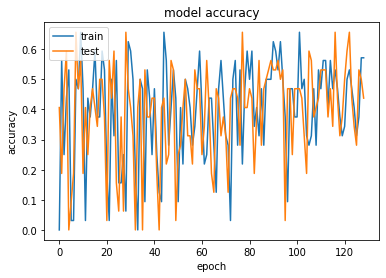

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

It is observed that the accuracy does not vary throughout the training and the value it takes is very low.

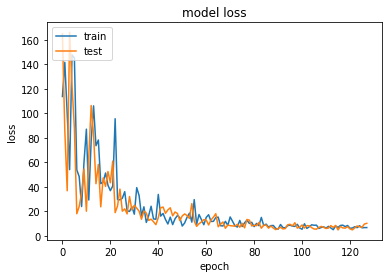

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'][1:])
plt.plot(history.history['val_loss'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In the case of loss, it is observed that as the epochs increase, their value decreases, which is the objective.

In [ ]:
model = load_model('resnet50flipped-freeze.h5')

In [ ]:
## Predict on test data
y_pred = model.predict(test_generator)

In [ ]:
test_labels = []
for image_batch, labels_batch in test_generator:
  for vector in labels_batch:
    test_labels.append(vector.numpy().astype(int))

y_real = np.array(test_labels)

In [ ]:
y_pred_class = y_pred.argmax(axis=1)

In [ ]:
y_real_class = y_real.argmax(axis=1)

Text(33.0, 0.5, 'Truth')

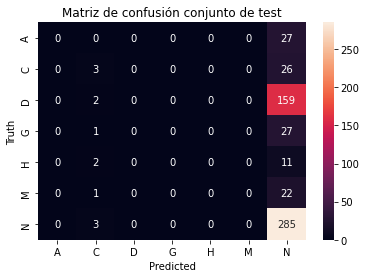

In [ ]:
labels = ['A', 'C', 'D', 'G', 'H', 'M', 'N']

cf_matrix = confusion_matrix(y_real_class, y_pred_class)
sns.heatmap(cf_matrix, annot=True, xticklabels=labels, yticklabels=labels, fmt='d')
plt.title('Matriz de confusión conjunto de test')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In this case, the model classifies all images within the class normal.

In [ ]:
print(classification_report(y_real_class, y_pred_class, target_names=labels))

              precision    recall  f1-score   support

           A       0.00      0.00      0.00        27
           C       0.25      0.10      0.15        29
           D       0.00      0.00      0.00       161
           G       0.00      0.00      0.00        28
           H       0.00      0.00      0.00        13
           M       0.00      0.00      0.00        23
           N       0.51      0.99      0.67       288

    accuracy                           0.51       569
   macro avg       0.11      0.16      0.12       569
weighted avg       0.27      0.51      0.35       569



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
